In [4]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [5]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_PPJ.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,1258615,2007-01-01
1,2007-2,1258615,2007-02-01
2,2007-3,2368954568,2007-03-01
3,2007-4,1018143,2007-04-01
4,2007-5,2168687787,2007-05-01


In [6]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()

tahun
2007-01-01       1258615
2007-02-01       1258615
2007-03-01    2368954568
2007-04-01       1018143
2007-05-01    2168687787
dtype: int64

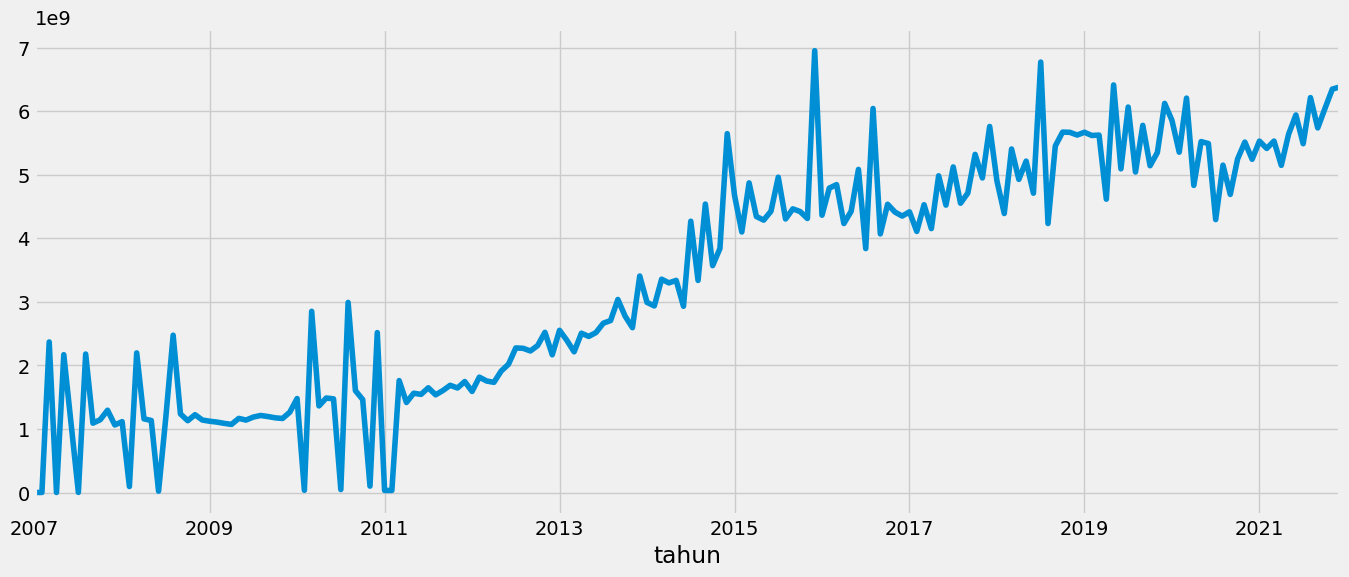

In [7]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [8]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(1, 1, 1), (0, 1, 1, 12), 7243.09192064552]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 1, 1),seasonal_order=(0, 1, 1, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3308.290
Date:                            Fri, 02 Dec 2022   AIC                           6624.579
Time:                                    11:07:01   BIC                           6636.701
Sample:                                01-01-2007   HQIC                          6629.503
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3961      0.148     -2.667      0.008      -0.687      -0.105
ma.L1         -0.6488      0.159   

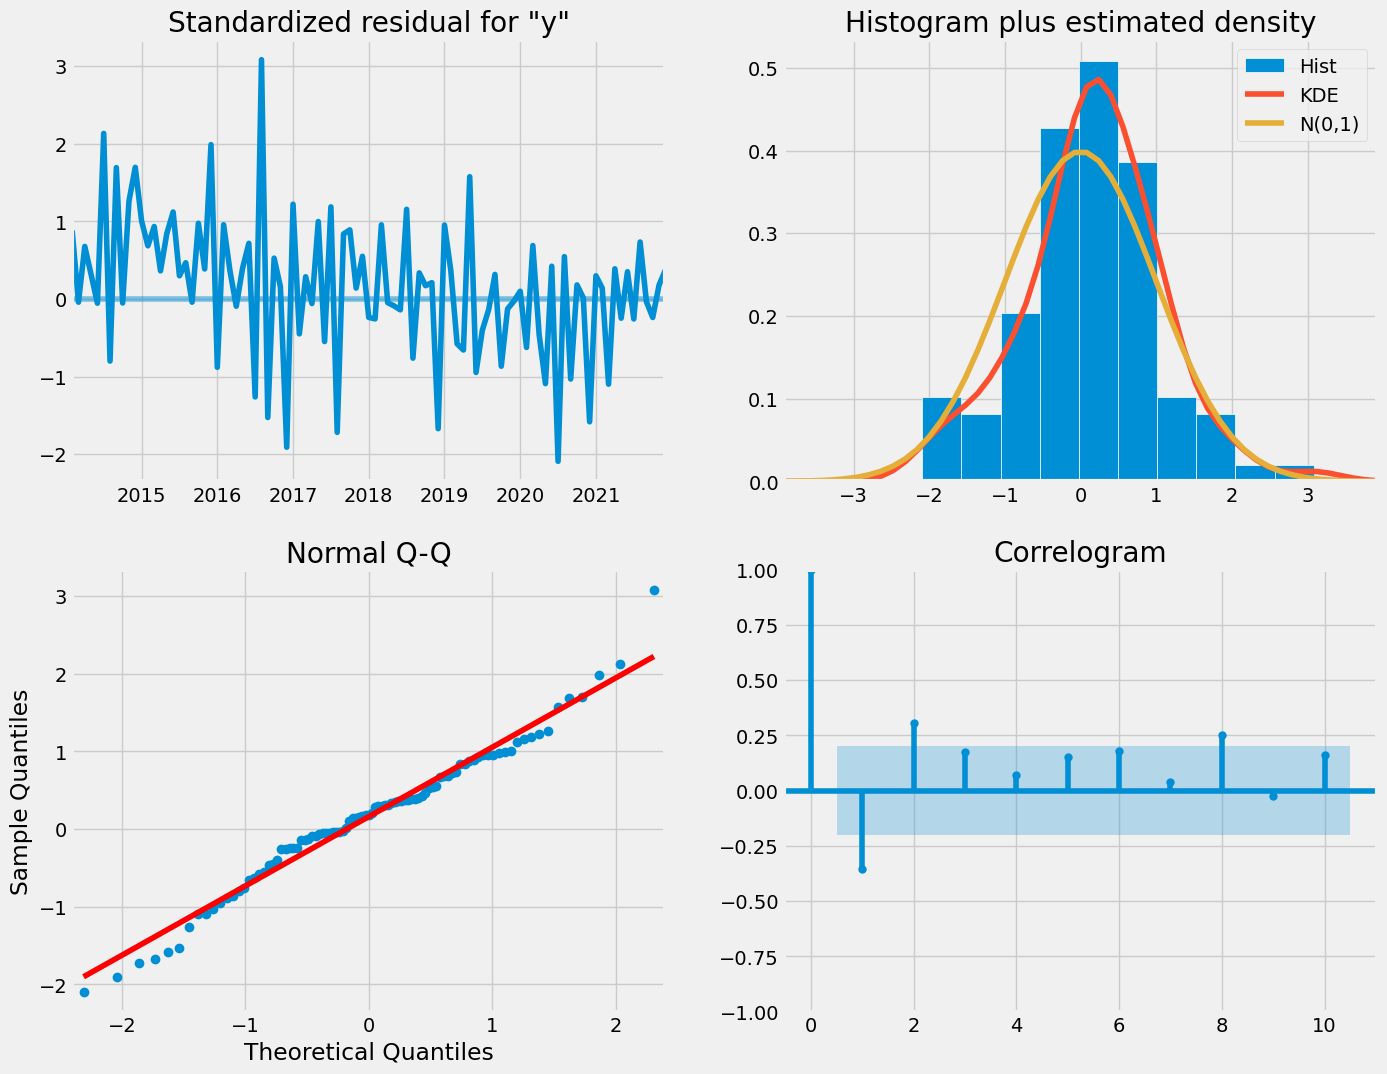

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

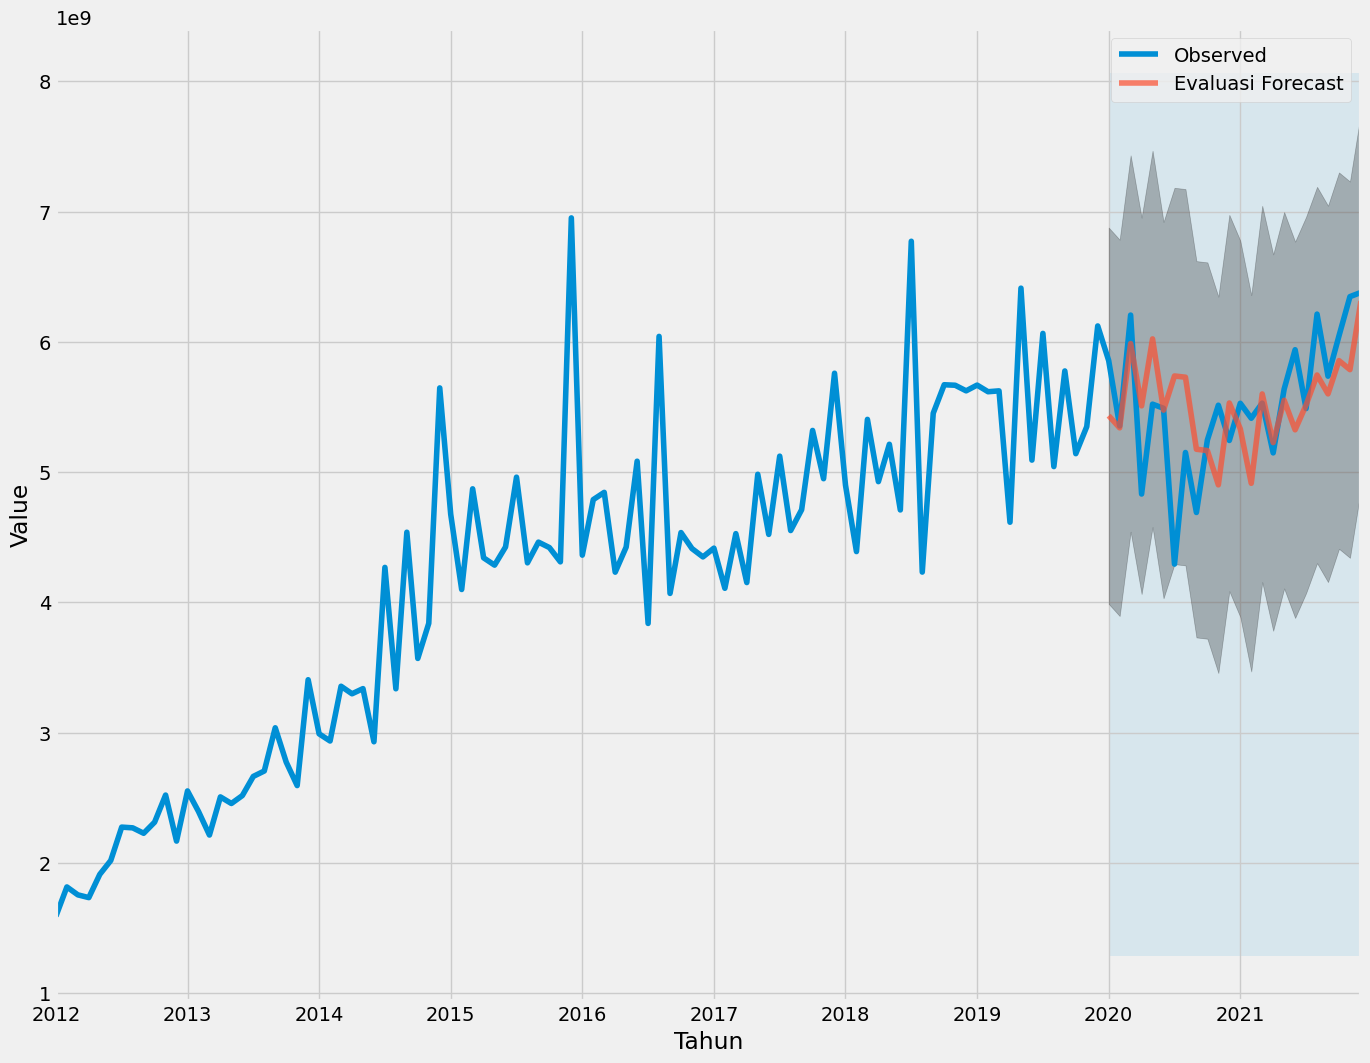

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [12]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()

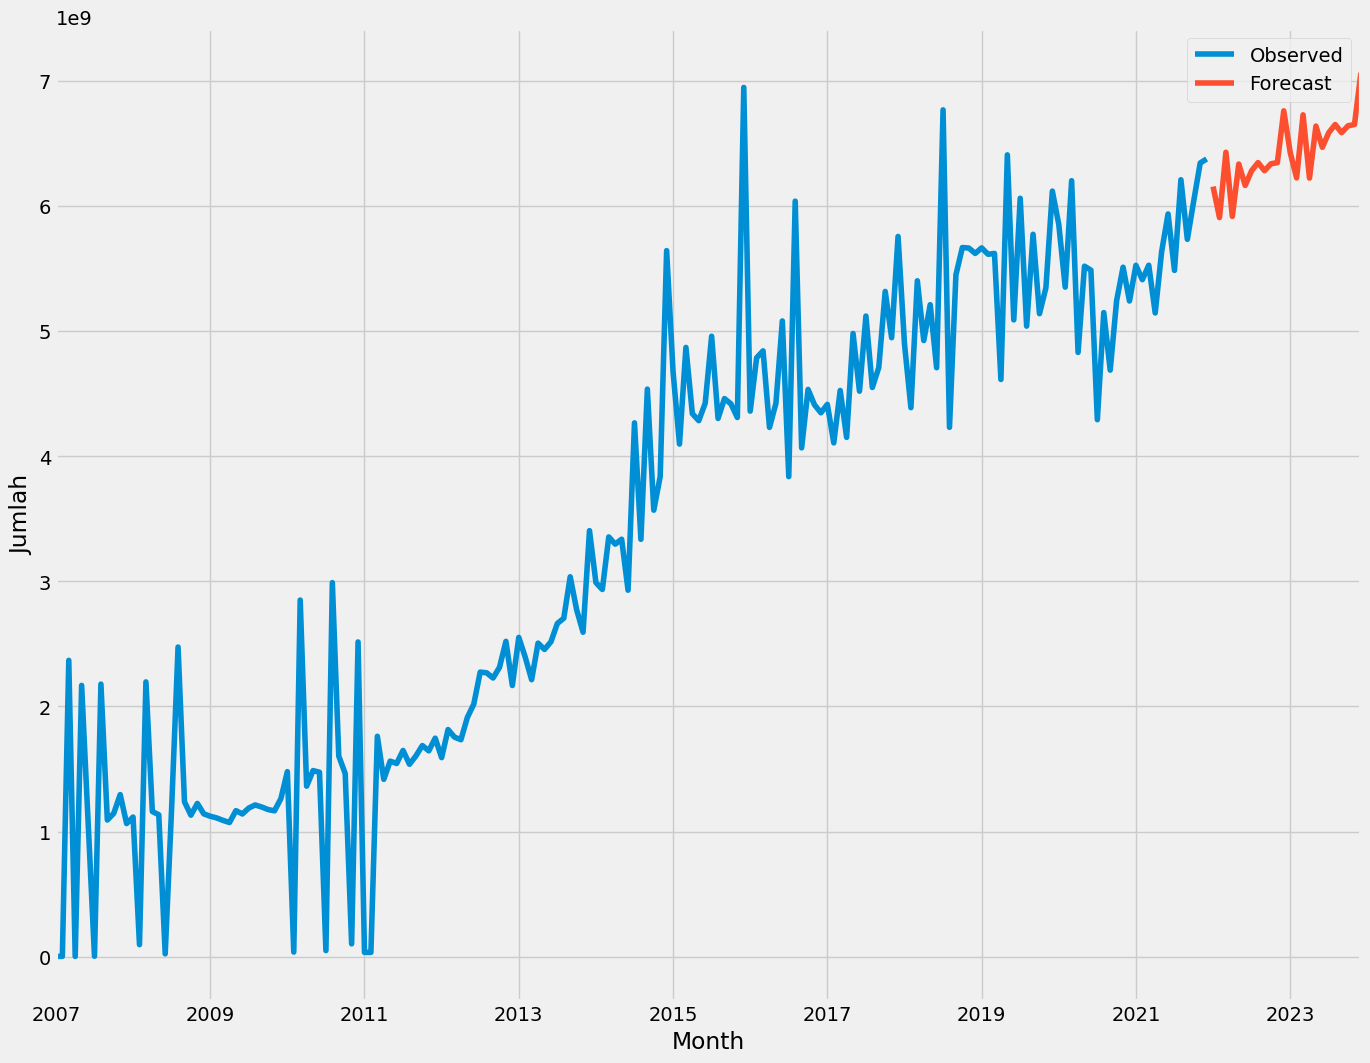

In [13]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()